In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

# learn t-SNE(Stochastic Neighbor Embedding) from implementation

[soure](https://lvdmaaten.github.io/tsne/)

- Similarity of data points in high dimensionalilty

$$ p_{j|i} = \frac{exp(-||x_i - x_j||^2/(2\sigma_i^2))}{\sum_{k \neq i} exp(-||x_i - x_k||^2/(2\sigma_i^2))} $$

- Similarity of data points in low dimensionalilty

$$ q_{j|i} = \frac{exp(-||y_i - y_j||^2)}{\sum_{k \neq i} exp(-||y_i - y_k||^2)} $$

preserve pairwise similarity between high-d and low-d : $p_{j|i} = q_{j|i}$
use KL divergence to be cose

$$ C = \sum_i KL(P_i || Q_i) = \sum_i\sum_jp_{j|i}log\frac{p_{j|i}}{q_{j|i}} $$


- different $\sigma_i$ cause different entropy
    - big $\sigma_i$, high entropy
    - small $\sigma_i$, low entropy

define perplexity to help find good $\sigma_i$

- perplexity

$$ Perp(P_i) = 2^{H(P_i)}, H(P_i) = -\sum_jp_{j|i}log_2p_{j|i}$$

for each $i$, use binary to search suitable $\sigma_i$

- in implementation `Hbeta`

use some trick to calculate entropy

$$ D_{j|i} = -||x_i - x_j||^2, \text{beta} = \frac{1}{2 \sigma_i^2}, p_{j|i} = \frac{exp(-D_{j|i}*beta)}{\sum_j exp(-D_{j|i}*beta)} \\
H(P_i) = -\sum_jp_{j|i}log_2p_{j|i} = \sum_j \frac{exp(-D_{j|i}*beta)}{\sum_j D_{j|i}*beta} log_2\frac{\sum_j exp(-D_{j|i}*beta)}{exp(-D_{j|i}*beta)} \\
= \sum_j \frac{exp(-D_{j|i}*beta)}{\sum_j exp(-D_{j|i}*beta)} (log(\sum_j exp(-D_{j|i}*beta)) - log (exp(-D_{j|i}*beta))) \\
= \sum_j \frac{exp(-D_{j|i}*beta) log(\sum_j D_{j|i}*beta)}{\sum_j exp(-D_{j|i}*beta)} + \frac{exp(-D_{j|i}*beta)D_{j|i}*beta)}{\sum_j exp(-D_{j|i}*beta)} \\
= log(sumP) + \frac{\sum_j p_jD_{j|i}beta}{sumP}, sumP = \sum_j p_j,p_j = exp(-D_{j|i}*beta)
$$

In [2]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to 
        reduce its dimensionality to no_dims dimensions.
    """
    
    # get n and d from shape
    (n, d) = X.shape
    
    # become X as centered data
    # use mean get 1xd array from n datas
    # and then expend to n*d array
    # sub with X
    X = X - np.tile(np.mean(X, axis=0), (n,1))
    
    # maximize W^T S W, solve eigen problem
    # S is covariance matrix
    (l, M) = np.linalg.eig(np.matmul(X.T, X))
    
    # use max no_dims principal compoment to reduce dimensions
    Y = np.matmul(X, M[:, 0:no_dims])
    return Y

def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """
    
    # compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    
    return H, P

def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """
    
    # initialize some variables
    
    # compute pairwise distances
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    
    
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)
    
    # loop over all datapoints
    for i in range(n):
        
        # compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])
        
        # evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
            
            # if not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.
            
            # recompute the value
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        # set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
        
    # return final P-matrix
    return P

In [3]:
# load minst2500 dataset
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")

X.shape, labels.shape

((2500, 784), (2500,))

# Add symmetric SNE

modify Q and gradient

In [4]:
def __tsne_gradient_descent(Y, dY, iY, gains, min_gain, momentum, eta):
    """
        return Y iY gains
    """
    gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
            (gains * 0.8) * ((dY > 0.) == (iY > 0.))
    gains[gains < min_gain] = min_gain
    iY = momentum * iY - eta * (gains * dY)
    Y = Y + iY
    Y = Y - np.tile(np.mean(Y, 0), (Y.shape[0], 1))
    
    return Y, iY, gains

def tsne(
    X=np.array([]), 
    no_dims=2, 
    initial_dims=50, 
    perplexity=30.0, 
    SNE=False
):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the 
        function is `Y = tsne.tsne(X, no_dims, perplexity), 
        where X is an NxD NumPy array.
    """
    
    # check inputs
    if not X.dtype == 'float':
        raise AttributeError("array X should have type float")
    if round(no_dims) != no_dims:
        raise AttributeError("number of dims must be an integer")
    
    # initialize variables
    
    # reduce X to initial_dims dimensions
    # because eigen vector is complex, just get real part
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))
    C = []
    Q = np.zeros((n, n))
    
    if SNE:
        # use same random initial values
        Y_SNE = Y.copy()
        dY_SNE = np.zeros((n, no_dims))
        iY_SNE = np.zeros((n, no_dims))
        gains_SNE = np.ones((n, no_dims))
        C_SNE = []
        Q_SNE = np.zeros((n, n))
    
    # compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.
    P = np.maximum(P, 1e-12)
    
    # run iterations
    for iter in range(max_iter):
        
        # compute pairwise affinities Q
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)
        if SNE:
            sum_Y_SNE = np.sum(np.square(Y_SNE), 1)
            num_SNE = -2. * np.dot(Y_SNE, Y_SNE.T)
            num_SNE = np.add(np.add(num_SNE, sum_Y_SNE).T, sum_Y_SNE)
            num_SNE = np.exp(-1*num_SNE)
            num_SNE[range(n), range(n)] = 0.
            Q_SNE = num_SNE / np.sum(num_SNE)
            Q_SNE = np.maximum(Q_SNE, 1e-12)
        
        # compute gradient
        PQ = P - Q
        if SNE:
            PQ_SNE = P - Q_SNE
        for i in range(n):
            dY[i, :] = np.sum(
                np.tile(
                    PQ[:, i] * num[:, i], 
                    (no_dims, 1)
                ).T * (Y[i, :] - Y), 
                0
            )
            if SNE:
                dY_SNE[i, :] = np.sum(
                    np.tile(
                        PQ_SNE[:,i], 
                        (no_dims, 1)
                    ).T * (Y_SNE[i, :] - Y_SNE), 
                    0
                )
        
        # perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
            
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))
        
        if SNE:
            Y_SNE, iY_SNE, gains_SNE = __tsne_gradient_descent(
                Y_SNE, 
                dY_SNE, 
                iY_SNE, 
                gains_SNE, 
                min_gain,
                momentum, 
                eta
            )
    
        # compute current value of cost function
        # use KL divergense
        if (iter + 1) % 10 == 0:
            C += [np.sum(P * np.log(P / Q))]
            if SNE:
                C_SNE += [np.sum(P * np.log(P / Q_SNE))]
                print('[{}] tsne error : {:.4f}, s-sne error : {:.4f}'.format(
                    iter+1, 
                    C[-1], 
                    C_SNE[-1])
                )
            else:
                print('[{}] tsne error : {:.4f}'.format(iter+1, C[-1]))
    
        # stop lying about P-values
        if iter == 100:
            P = P / 4.
    
    # return solution
    if not SNE:
        return Y, P, Q, C
    else:
        return (Y, Y_SNE), P, (Q, Q_SNE), (C, C_SNE)

In [50]:
%%time
Y = tsne(X, 2, 50, 20.0)

CPU times: user 17min 5s, sys: 8min 51s, total: 25min 57s
Wall time: 14min 23s


In [5]:
%%time
Ys, P, Qs, Cs = tsne(X, 2, 50, 32.0, SNE=True)

[10] tsne error : 21.7777, s-sne error : 21.7306
[20] tsne error : 19.2186, s-sne error : 17.2137
[30] tsne error : 16.4275, s-sne error : 15.9349
[40] tsne error : 15.6444, s-sne error : 16.1597
[50] tsne error : 15.4800, s-sne error : 16.0616
[60] tsne error : 15.4267, s-sne error : 16.0609
[70] tsne error : 15.4195, s-sne error : 16.0728
[80] tsne error : 15.4306, s-sne error : 16.0607
[90] tsne error : 15.4258, s-sne error : 16.0607
[100] tsne error : 15.4155, s-sne error : 16.0614
[110] tsne error : 2.1687, s-sne error : 2.0460
[120] tsne error : 1.8707, s-sne error : 1.9350
[130] tsne error : 1.6783, s-sne error : 1.9424
[140] tsne error : 1.5477, s-sne error : 1.9580
[150] tsne error : 1.4533, s-sne error : 1.9590
[160] tsne error : 1.3816, s-sne error : 1.9554
[170] tsne error : 1.3264, s-sne error : 1.9543
[180] tsne error : 1.2823, s-sne error : 1.9546
[190] tsne error : 1.2461, s-sne error : 1.9549
[200] tsne error : 1.2159, s-sne error : 1.9549
[210] tsne error : 1.1904, s-

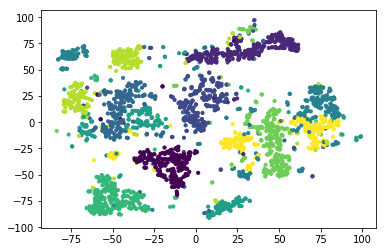

In [172]:
plt.scatter(Ys[0][:,0], Ys[0][:,1], s=10, c=labels)

In [13]:
def showByClustering(Y, labels, size=20, title=''):
    if not isinstance(Y, list):
        Y = [Y]
    if not isinstance(title, list):
        title = [title]
    if len(Y) != len(title):
        raise AttributeError('number is different')
    
    n = len(Y)
    
    plt.figure(figsize=(10*n,7.5))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.title(title[i])
        y = Y[i]
        for l in np.unique(labels):
            plt.scatter(
                y[labels==l,0], 
                y[labels==l,1], 
                s=size, 
                label=str(int(l))
            )
        plt.legend()
    
    plt.show()

def showCostCurve(Cs, labels=None, title=''):
    plt.figure(figsize=(10,7.5))
    plt.title(title)
    if type(labels) == type(None):
        labels = ['']*len(Cs)
    
    for idx, C in enumerate(Cs):
        plt.plot(C, label=labels[idx])
    
    plt.xlabel('Iterations per 10')
    plt.ylabel('KL divergence (Cost)')
    plt.legend()
    plt.show()

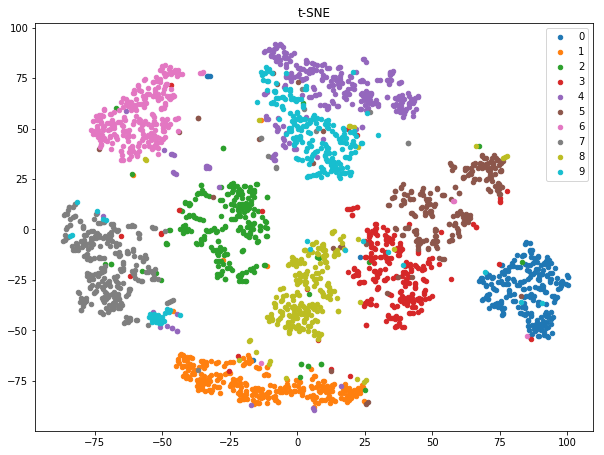

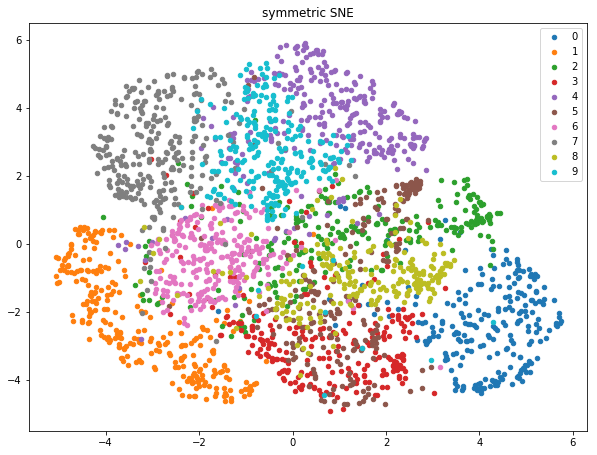

In [134]:
showByClustering(Ys[0], labels, title='t-SNE')
showByClustering(Ys[1], labels, title='symmetric SNE')

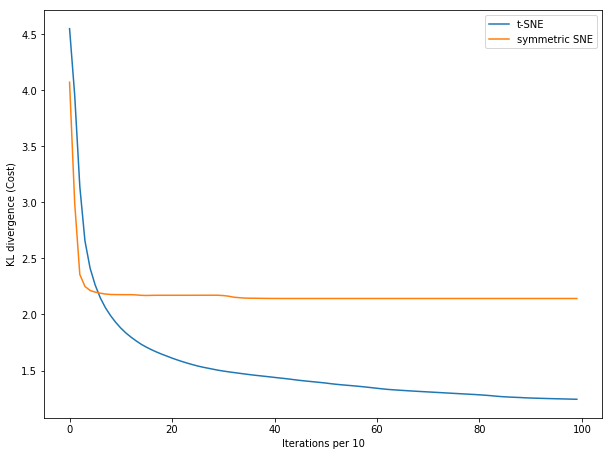

In [173]:
showCostCurve(Cs, labels=['t-SNE', 'symmetric SNE'])

In [151]:
np.savetxt('./datas/t-SNE.txt', Ys[0])
np.savetxt('./datas/s-SNE.txt', Ys[1])

In [66]:
perplexitys = 2**np.arange(2,12)
Ys_diffp = {}
P_diffp = {}
Qs_diffp = {}
Cs_diffp = {}
perplexitys

array([   4,    8,   16,   32,   64,  128,  256,  512, 1024, 2048])

In [164]:
%%time
filepath='./datas/{}-{:.0f}.txt'
for p in perplexitys:
    display.clear_output(wait=True)
    print('\ndo perplexity = {}\n'.format(p))
    Ys_diffp[p], P_diffp[p], Qs_diffp[p], Cs_diffp[p] = tsne(X, 2, 50, p, SNE=True)
    np.savetxt(filepath.format('t-SNE', p), Ys_diffp[p][0])
    np.savetxt(filepath.format('s-SNE', p), Ys_diffp[p][1])


do perplexity = 2048

CPU times: user 331 ms, sys: 45.9 ms, total: 377 ms
Wall time: 364 ms


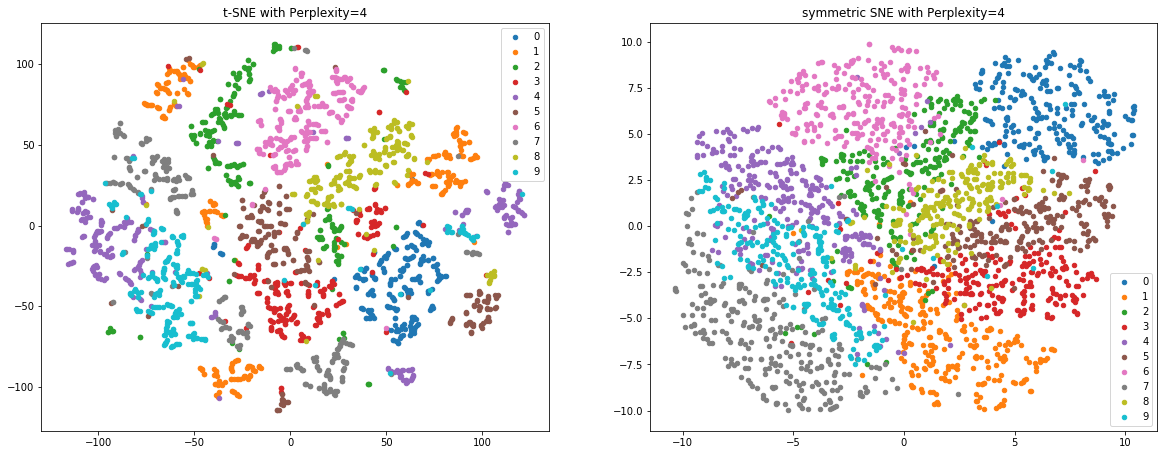

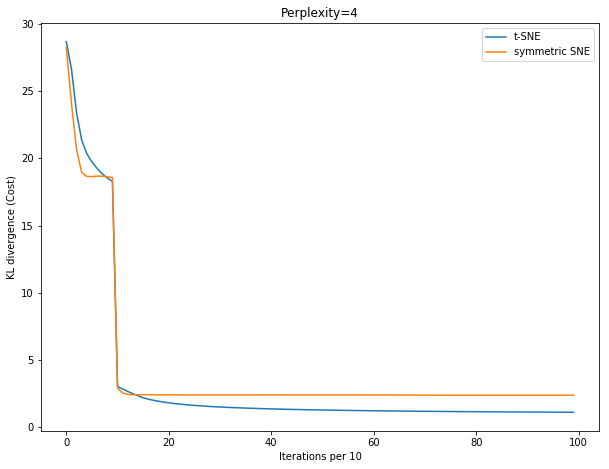

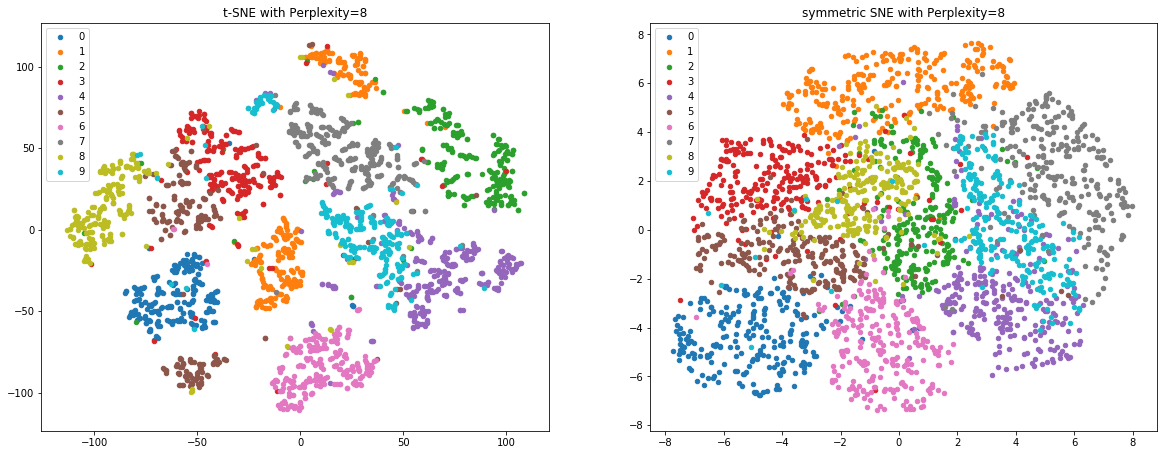

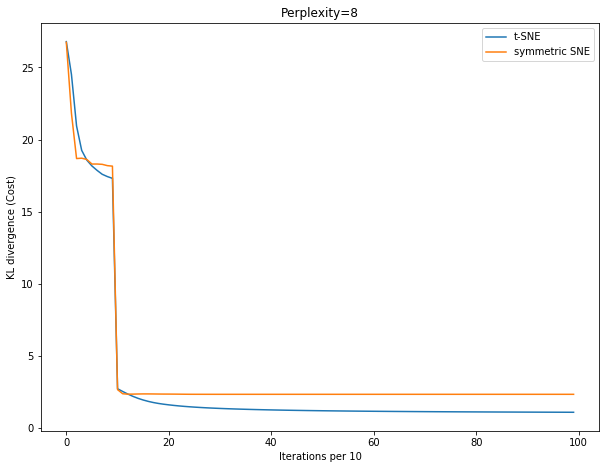

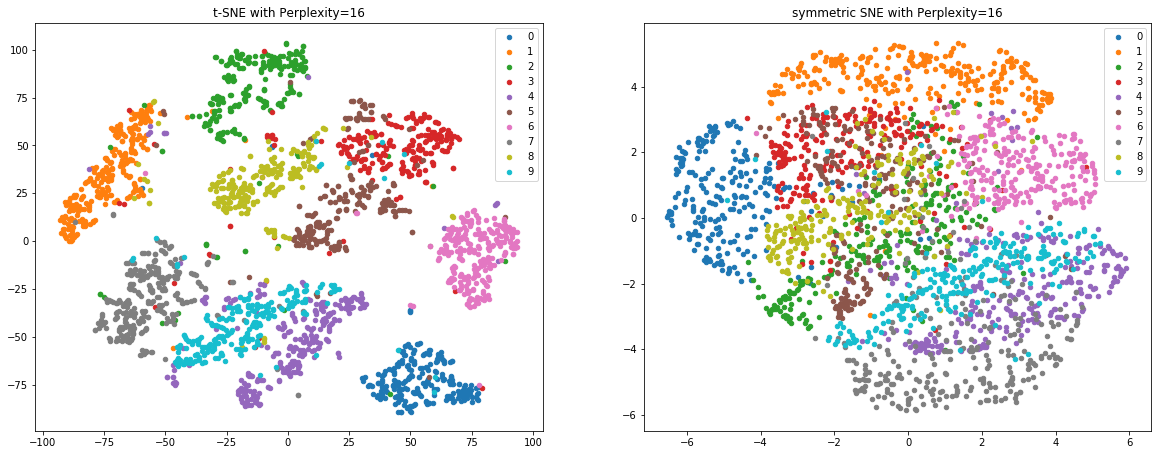

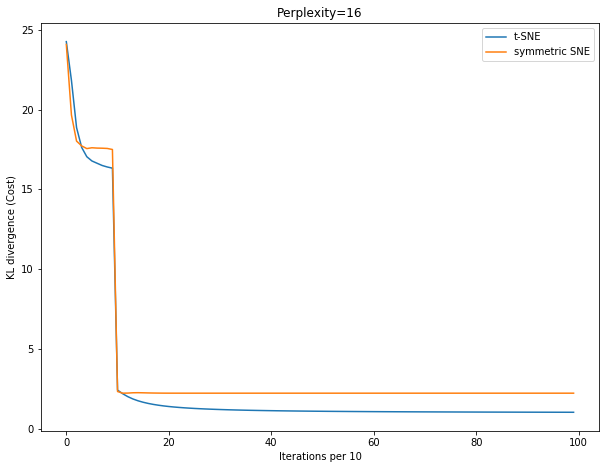

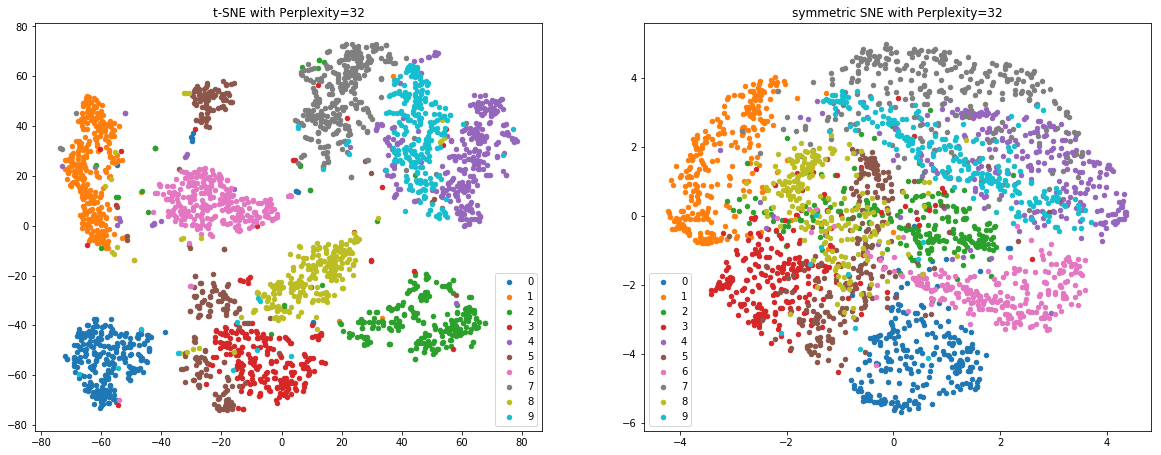

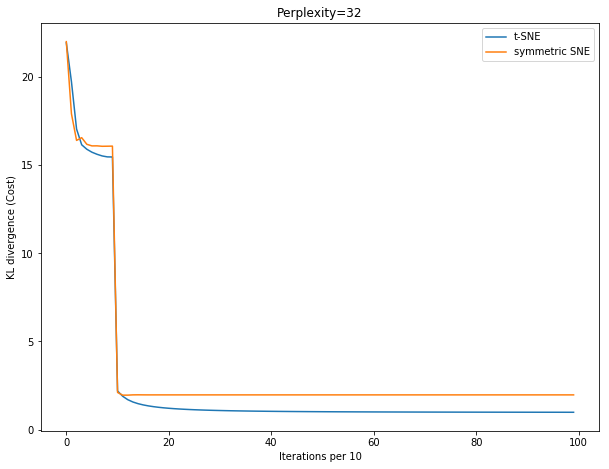

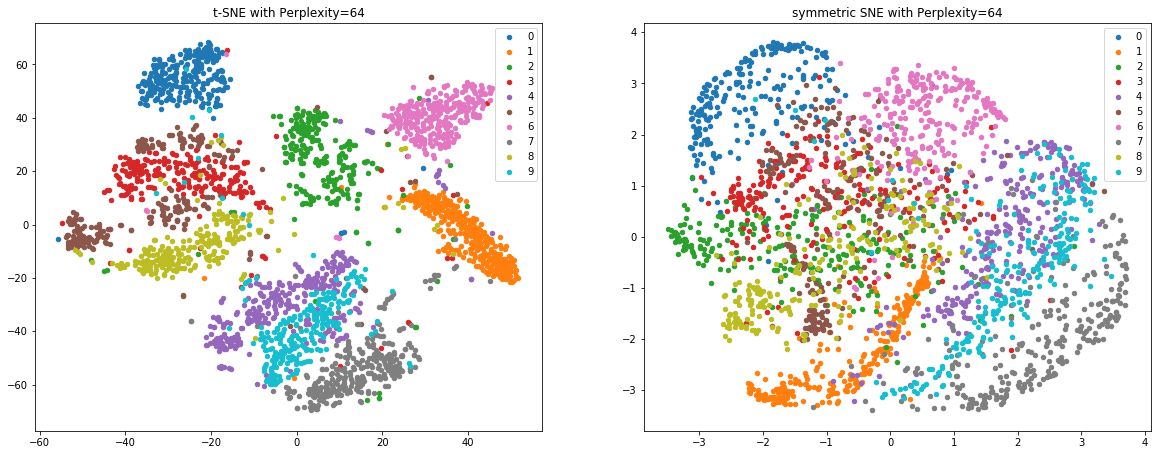

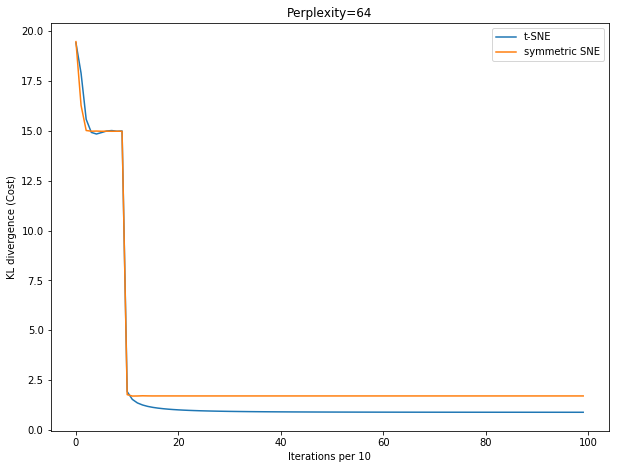

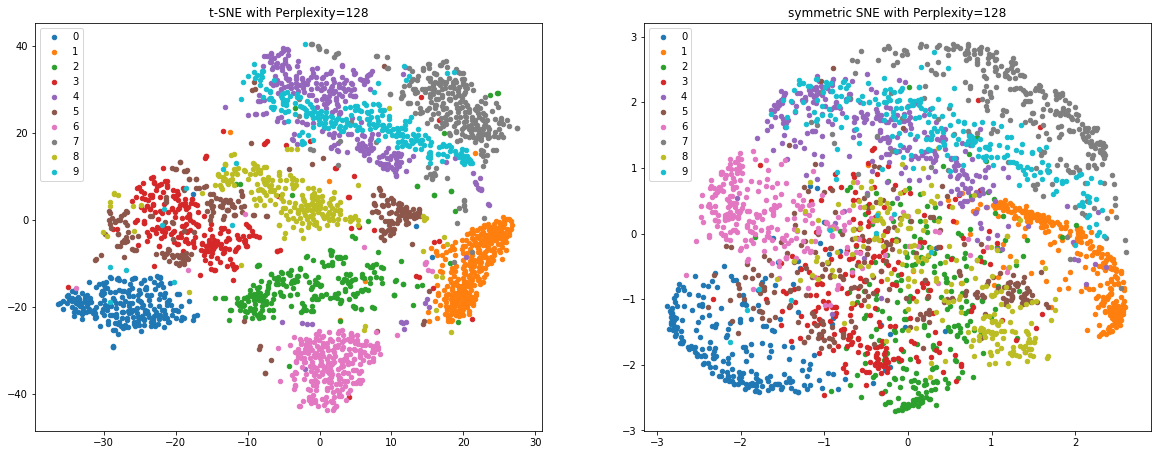

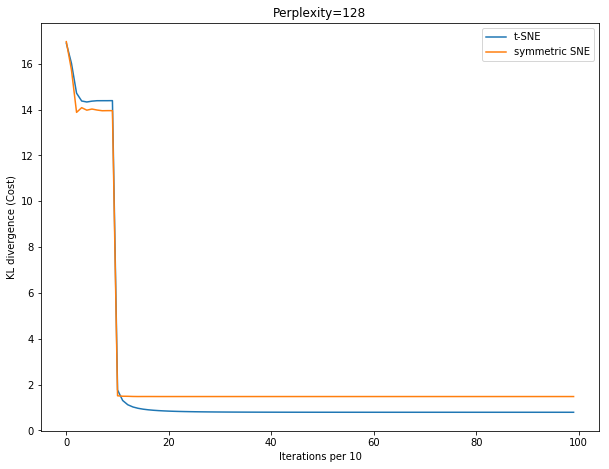

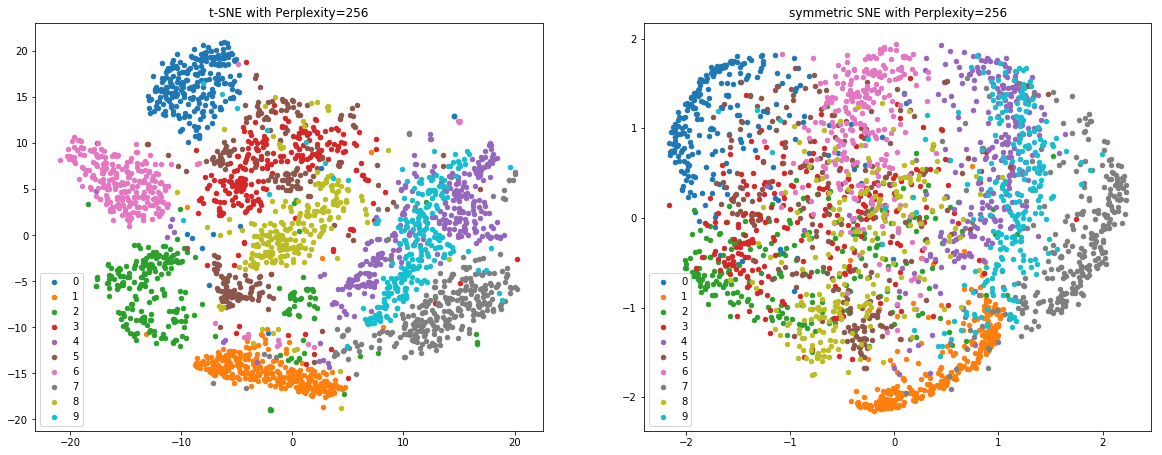

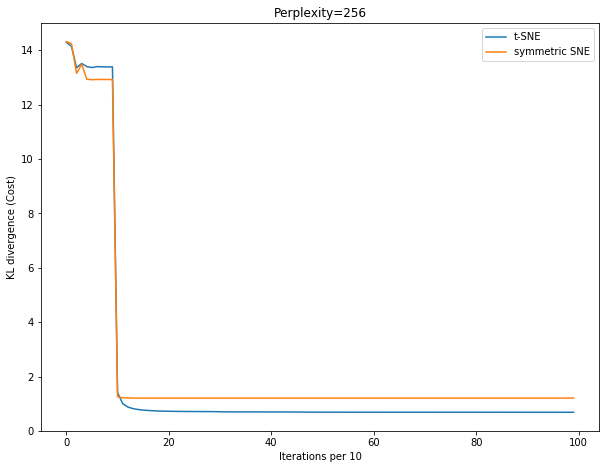

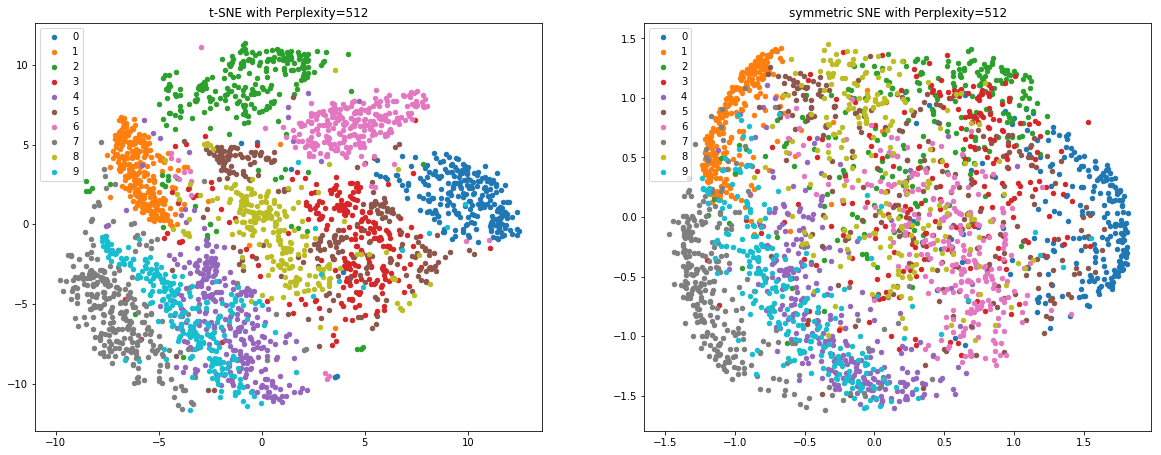

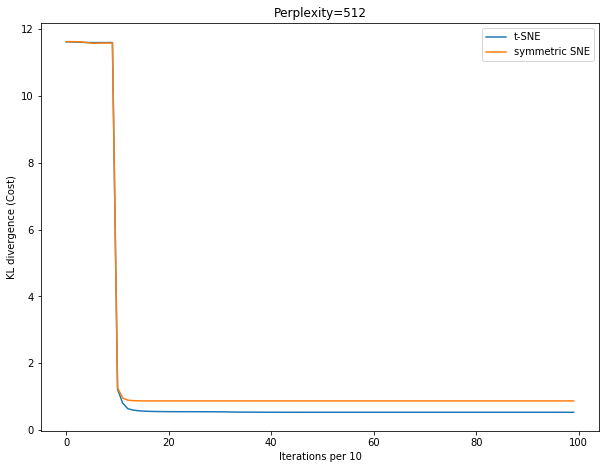

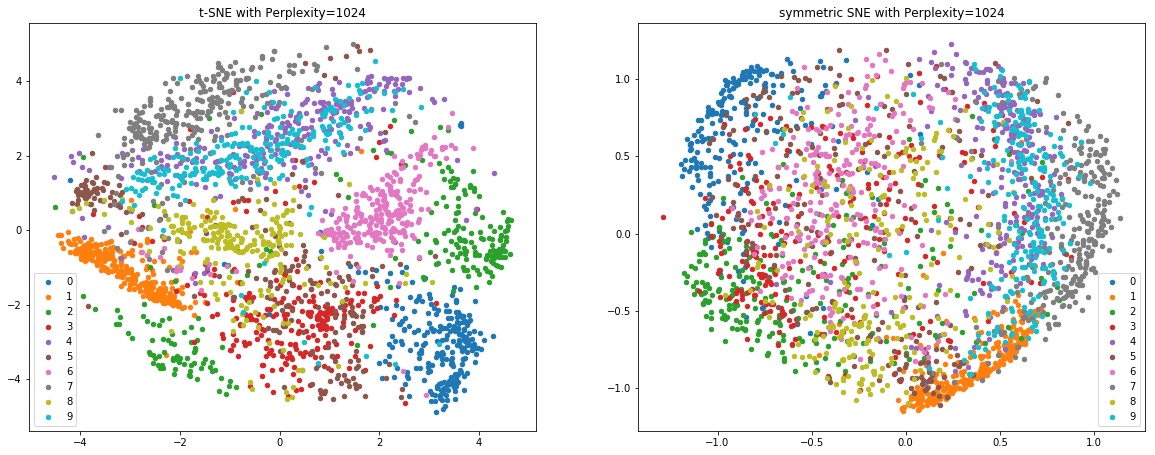

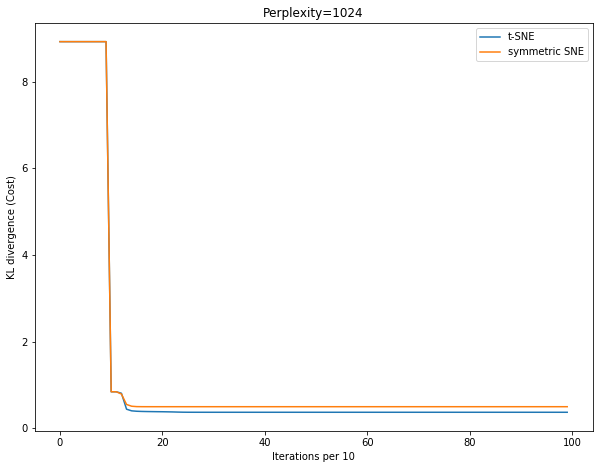

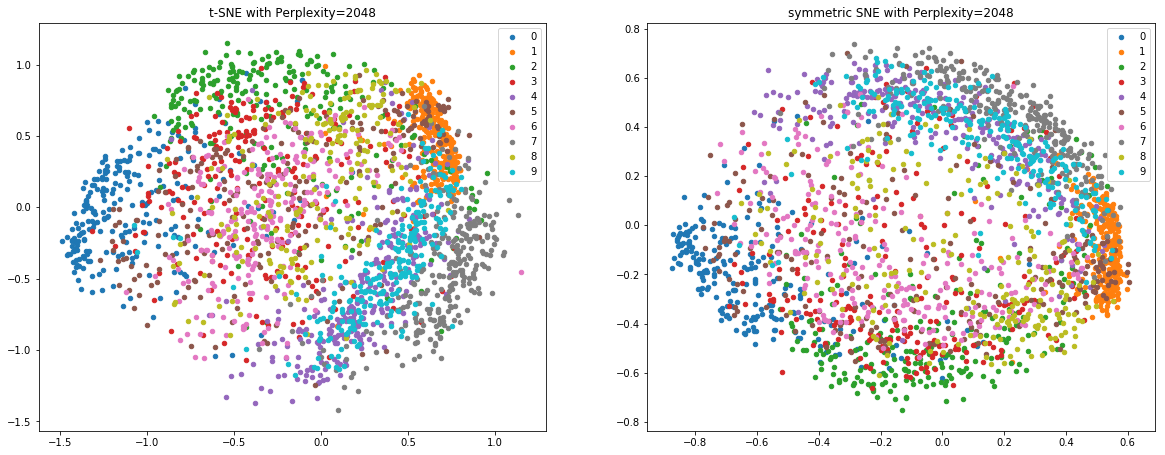

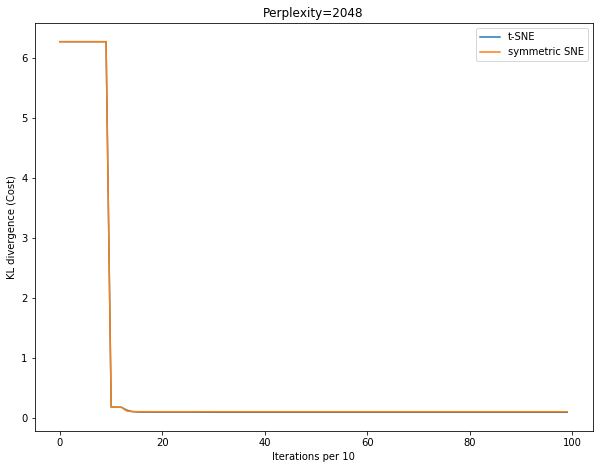

In [195]:
for p in perplexitys:
    showByClustering(list(Ys_diffp[p]), labels, title=['t-SNE with Perplexity={:.0f}'.format(p), 'symmetric SNE with Perplexity={:.0f}'.format(p)])
    showCostCurve(Cs_diffp[p], labels=['t-SNE', 'symmetric SNE'], title='Perplexity={:.0f}'.format(p))

In [83]:
X_PCA = pca(X, 50).real

In [84]:
%%time
perplexity = 20.0
P_noPCA = x2p(X, perplexity=perplexity)

CPU times: user 36.5 s, sys: 631 ms, total: 37.1 s
Wall time: 35.3 s


In [85]:
%%time
P_PCA = x2p(X_PCA, perplexity=perplexity)

CPU times: user 33 s, sys: 525 ms, total: 33.5 s
Wall time: 32.8 s


/home/grass0756110/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


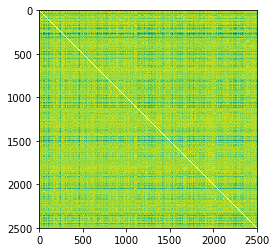

/home/grass0756110/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


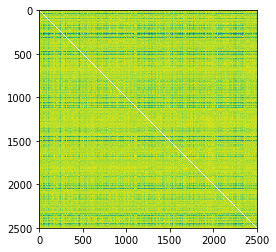

In [92]:
plt.imshow(np.log(P_noPCA))
plt.show()
plt.imshow(np.log(P_PCA))
plt.show()

In [89]:
np.sum((P_noPCA - P_PCA)**2)

42.28044078945112

In [21]:
from mpl_toolkits.mplot3d import Axes3D

In [11]:
#np.meshgrid(np.arange(2500), np.arange(2500))[0].reshape((1,-1))

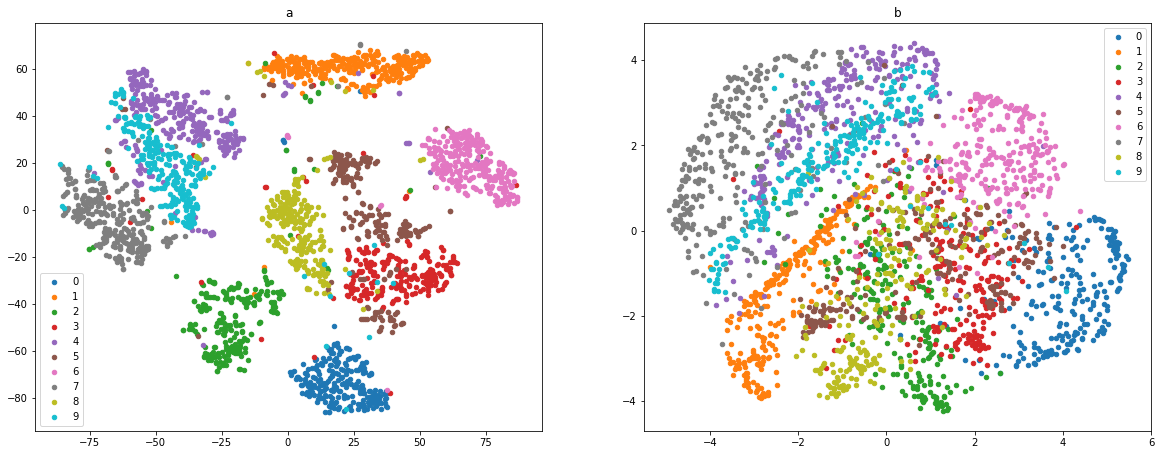

In [15]:
showByClustering(list(Ys), labels, title=['a','b'])

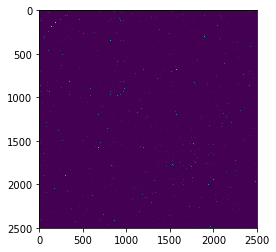

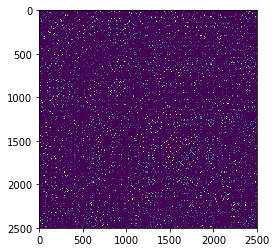

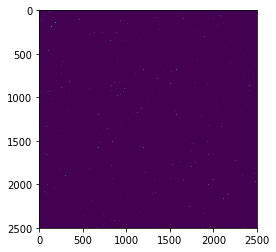

In [20]:
def __mybins(X, bins=10, ds=None):
    if type(ds) == type(None):
        m = np.min(X)
        d = (np.max(X) - np.min(X))/bins
        ds = np.array([d*(i+1) for i in range(bins)]) + m
    else:
        bins = len(ds)
    bin_count_t = np.zeros(bins)
    bin_count = np.zeros(bins)
    for i,d in enumerate(ds):
        bin_count_t[i] = np.count_nonzero(X < d)
    bin_count[0] = bin_count_t[0]
    for i in range(bins-1):
        bin_count[i+1] = bin_count_t[i+1] - bin_count_t[i]
    
    return bin_count, ds

def showPairwiseSimilarities(dis, labels, title='', rn=1):
    if not isinstance(dis, list):
        dis = [dis]
    if not isinstance(title, list):
        title = [title]
    if len(dis) != len(title):
        raise AttributeError('number is different')
    
    n = len(dis)
    sort_idx = np.concatenate([np.where(labels==l)[0] for l in np.unique(labels)])
    
    plt.figure(figsize=(10*n,7.5*(1 + rn)))
    
    dis = [np.log(d[:, sort_idx][sort_idx, :]) for d in dis]
    all_min = min([np.min(d) for d in dis])
    all_max = max([np.max(d) for d in dis])
    
    
    rnd_idx = np.random.randint(0, labels.shape[0], size=rn*3)
    
    for i in range(n):
        plt.subplot(rn+1,n,i+1)
        plt.title(title[i])
        im = plt.imshow(dis[i], cmap='gray', vmin=all_min, vmax=all_max)
        plt.colorbar(im)
    
    bin_nu = 10
    bin_w = 0.3
    
    for i in range(rn):
        for j in range(n):
            plt.subplot(rn+1,n,j+1+n*(i+1))
            idx = rnd_idx[i*rn + j]
            plt.title('{} idx distribution'.format(idx))
            tmp_idx = np.concatenate([np.r_[:idx], np.r_[idx+1:labels.shape[0]]])
            
            _, bin_x = __mybins
            
            for k in range(n):
                plt.plot(dis[k][idx, tmp_idx][tmp_idx2], '.', label=title[k])
            plt.legend()
    
    plt.show()

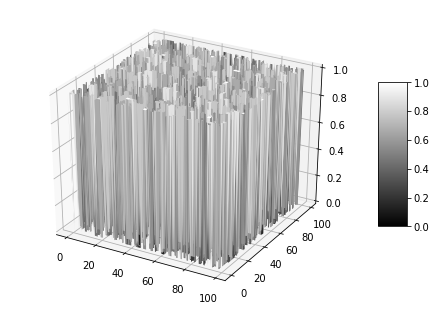

In [36]:
fig = plt.figure()
ax = Axes3D(fig)

X = np.arange(100)
Y = np.arange(100)
X, Y = np.meshgrid(X, Y)
Z = np.random.randint(0,2,10000).reshape((100,100))

surf = ax.plot_surface(X,Y,Z, cmap='gray')

ax.set_zlim(0.0,1.0)

fig.colorbar(surf, shrink=0.5, aspect=5)

In [35]:
def __mybins(X, bins=10, ds=None):
    if type(ds) == type(None):
        m = np.min(X)
        d = (np.max(X) - np.min(X))/bins
        ds = np.array([d*(i+1) for i in range(bins)]) + m
    else:
        bins = len(ds)
    bin_count_t = np.zeros(bins)
    bin_count = np.zeros(bins)
    for i,d in enumerate(ds):
        bin_count_t[i] = np.count_nonzero(X < d)
    bin_count[0] = bin_count_t[0]
    for i in range(bins-1):
        bin_count[i+1] = bin_count_t[i+1] - bin_count_t[i]
    
    return bin_count, ds

def showPairwiseSimilarities(dis, labels, title='', rn=1):
    if not isinstance(dis, list):
        dis = [dis]
    if not isinstance(title, list):
        title = [title]
    if len(dis) != len(title):
        raise AttributeError('number is different')
    
    n = len(dis)
    sort_idx = np.concatenate(
        [np.where(labels==l)[0] for l in np.unique(labels)]
    )
    
    plt.figure(figsize=(10*n,7.5))
    
    dis = [np.log(d[:, sort_idx][sort_idx, :]) for d in dis]
    all_min = min([np.min(d) for d in dis])
    all_max = max([np.max(d) for d in dis])
    
    
    rnd_idx = np.random.randint(0, labels.shape[0], size=rn*3)
    
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.title(title[i])
        im = plt.imshow(dis[i], cmap='gray', vmin=all_min, vmax=all_max)
        plt.colorbar(im)
    
    plt.show()
    
    bin_nu = 10
    bin_w = 0.3
    
    for i in range(rn):
        plt.figure(figsize=(10*n,7.5))
        for j in range(n):
            plt.subplot(1,n,j+1)
            idx = rnd_idx[i*rn + j]
            plt.title('{} idx distribution'.format(idx))
            tmp_idx = np.concatenate(
                [np.r_[:idx], np.r_[idx+1:labels.shape[0]]]
            )
            
            _, bin_x = __mybins(dis[0][idx, tmp_idx], bins=bin_nu)
            bin_x_start = np.arange(bin_nu) - ((bin_w*n)/2.0)
            
            for k in range(n):
                bin_y, _ = __mybins(dis[k][idx, tmp_idx], ds=bin_x)
                plt.bar(
                    bin_x_start + ((k+0.5)*bin_w), 
                    bin_y, 
                    width=bin_w, 
                    label=title[k]
                )
           
            plt.xticks(range(bin_nu),['{:.2f}'.format(x) for x in bin_x])
            plt.legend()
    
        plt.show()

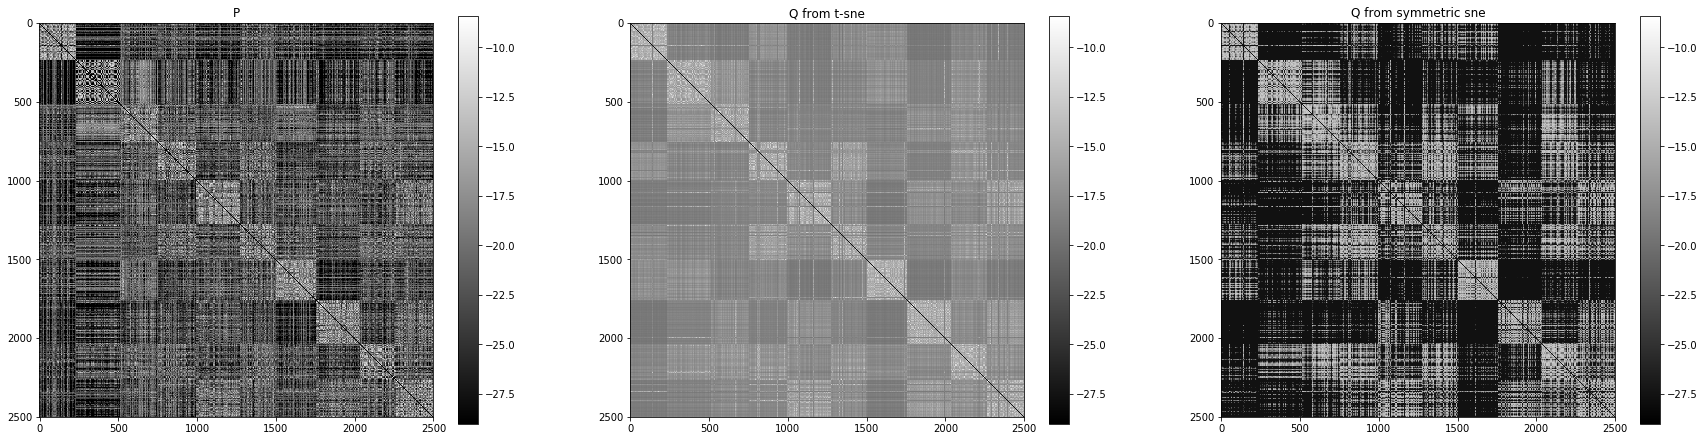

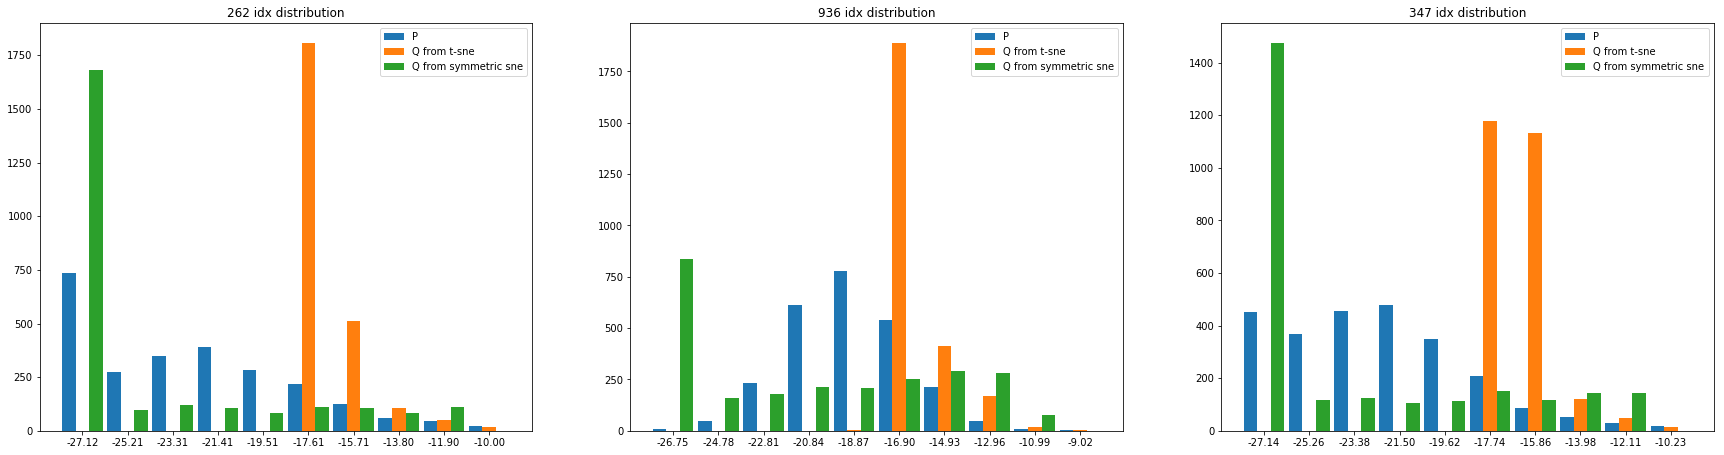

In [36]:
showPairwiseSimilarities([P]+list(Qs), labels, title=['P', 'Q from t-sne', 'Q from symmetric sne'], rn=1)

In [184]:
np.random.randint(0,2500, size=1).shape

(1,)

In [102]:
sort_idx = np.concatenate([np.where(labels==l)[0] for l in np.unique(labels)])
sort_idx.shape

(2500,)

In [80]:
np.count_nonzero(np.log(tmp+1) < 0.01)

6180558

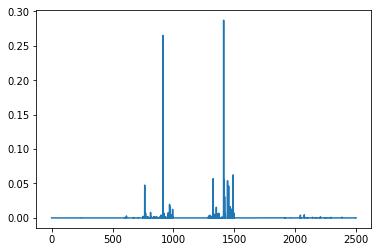

In [96]:
plt.plot(tmp[0,sort_idx].reshape((-1)))

In [103]:
tmp2 = tmp[:, sort_idx][sort_idx, :]
tmp2.shape

(2500, 2500)

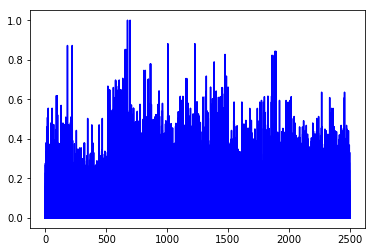

In [110]:
for i in range(2500):
    plt.plot(tmp2[i,:], c='b')

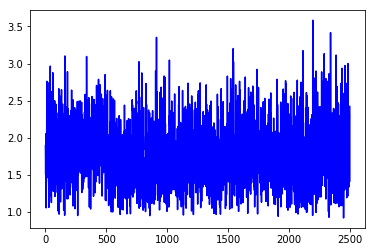

In [111]:
plt.plot(np.sum(tmp2, axis=0), c='b')

In [123]:
sort_idx_p = np.argsort(P.reshape(-1))
sort_idx_p.shape

(6250000,)

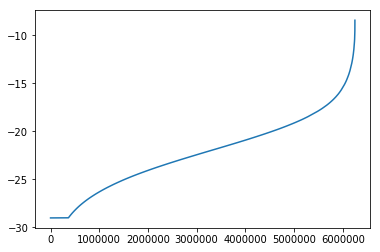

In [124]:
plt.plot(np.log((P.reshape(-1)[sort_idx_p])))

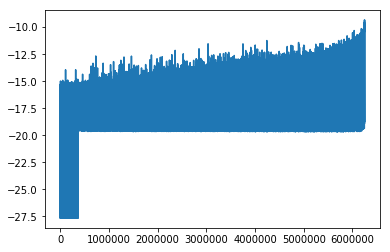

In [125]:
plt.plot(np.log((Qs[0].reshape(-1)[sort_idx_p])))

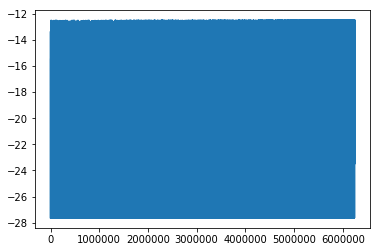

In [126]:
plt.plot(np.log((Qs[1].reshape(-1)[sort_idx_p])))

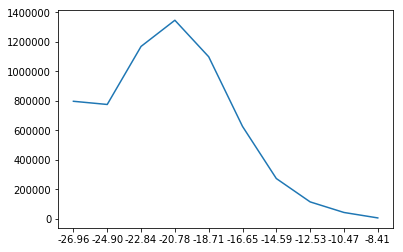

CPU times: user 560 ms, sys: 252 ms, total: 811 ms
Wall time: 532 ms


In [156]:
%%time
import math
b, b_x = __mybins(np.log(P.reshape(-1)))
plt.plot(b)
plt.xticks(range(10),['{:.2f}'.format(x) for x in b_x])
plt.show()

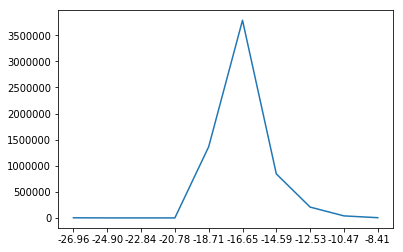

In [157]:
b, _ = __mybins(np.log(Qs[0].reshape(-1)), ds=b_x)
plt.plot(b)
plt.xticks(range(10),['{:.2f}'.format(x) for x in b_x])
plt.show()

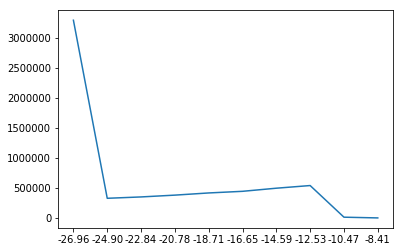

In [158]:
b, b_x = __mybins(np.log(Qs[1].reshape(-1)), ds=b_x)
plt.plot(b)
plt.xticks(range(10),['{:.2f}'.format(x) for x in b_x])
plt.show()

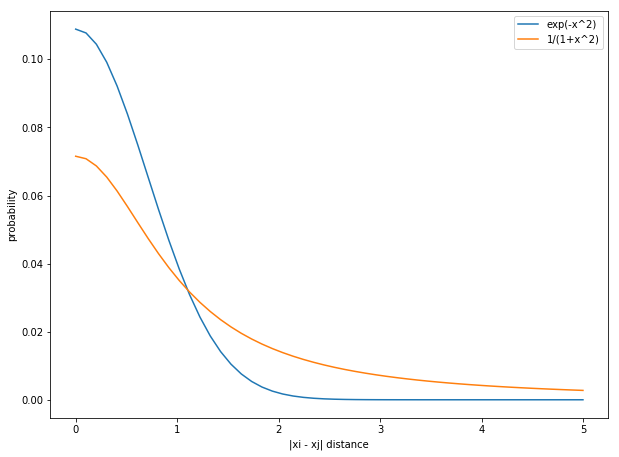

In [65]:
plt.figure(figsize=(10,7.5))
x = np.linspace(0, 5, num=50)
y1 = np.exp(-x**2)
y1 = y1 / np.sum(y1)
plt.plot(x, y1, label='exp(-x^2)')
y2 = 1/(1+x**2)
y2 = y2 / np.sum(y2)
plt.plot(x, y2, label='1/(1+x^2)')
plt.xlabel('|xi - xj| distance')
plt.ylabel('probability')
plt.legend()

In [67]:
testP = []

for p in perplexitys:
    tmpP = x2p(X, perplexity=p)
    testP += [tmpP]

/home/grass0756110/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/grass0756110/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/grass0756110/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [69]:
testP2 = []
for tp in testP:
    tp = tp + tp.T
    tp = tp / np.sum(tp)
    tp = np.maximum(tp, 1e-12)
    testP2 += [tp]

/home/grass0756110/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in maximum
  """


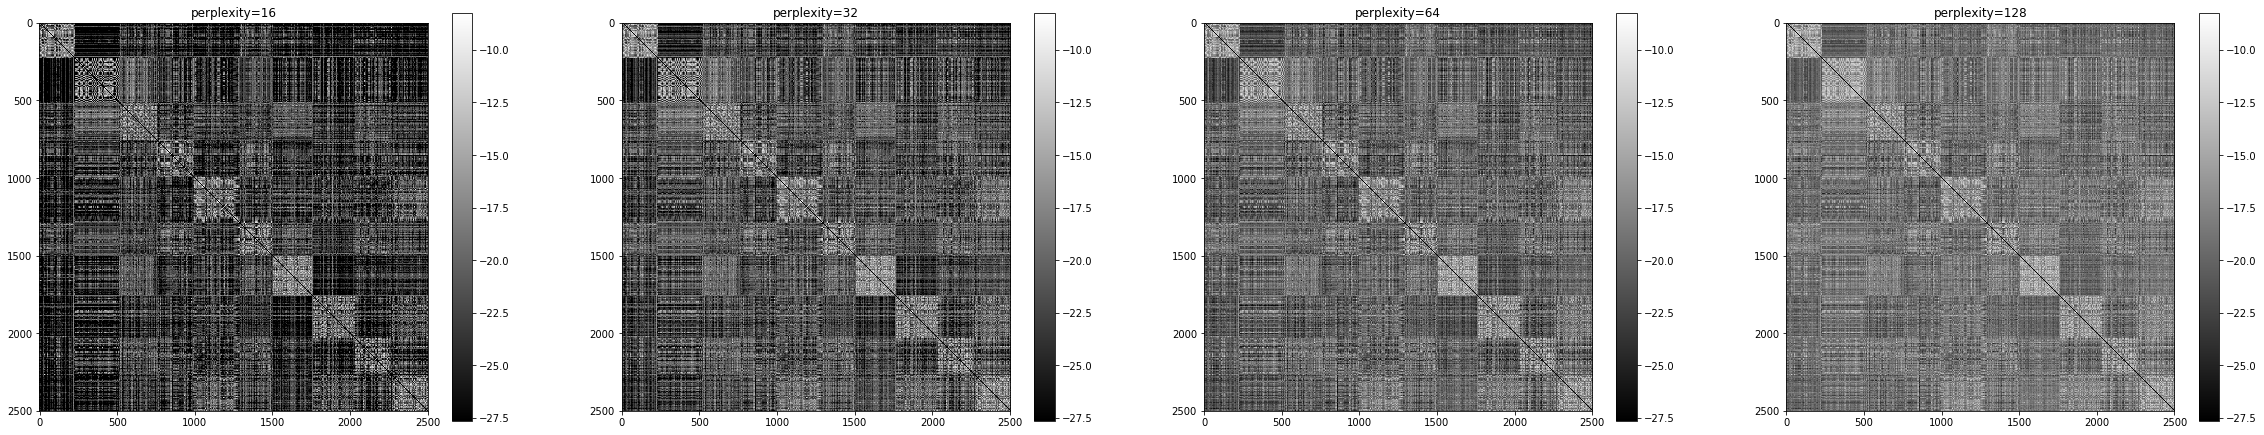

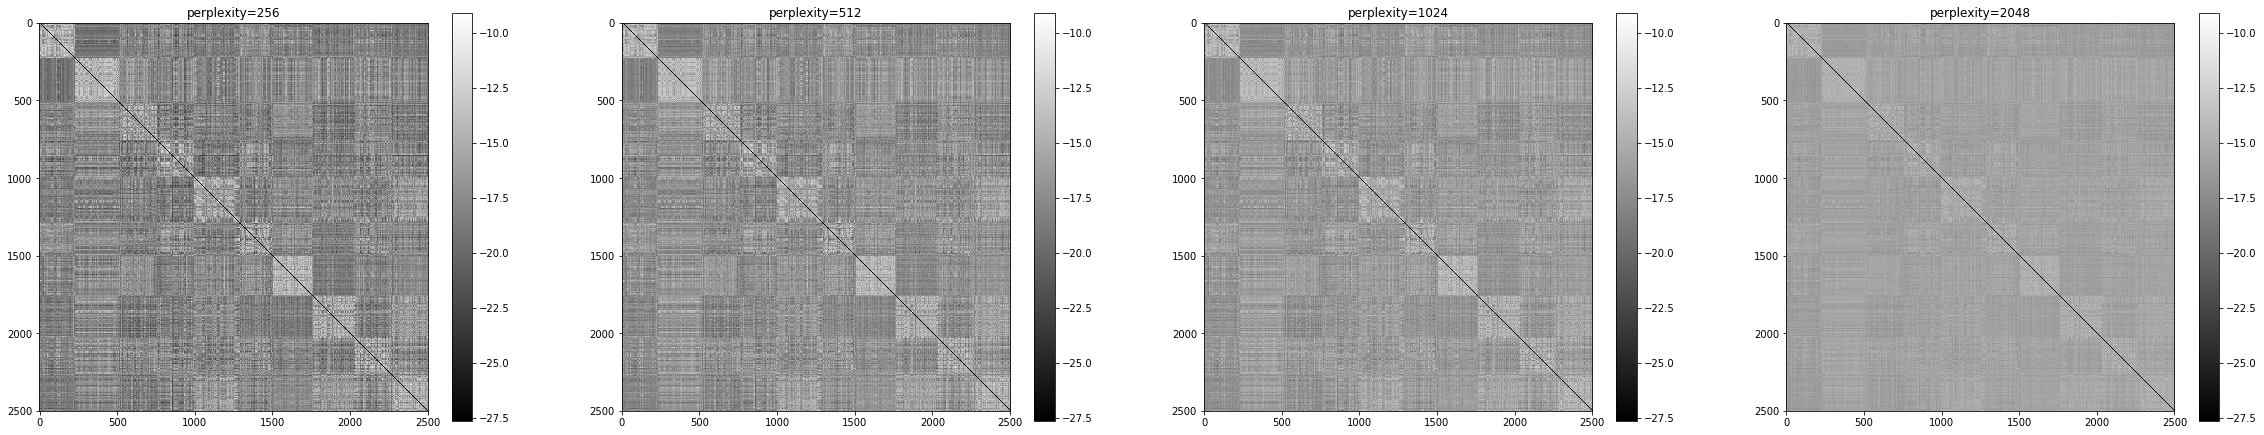

In [78]:
showPairwiseSimilarities(testP2[2:6], labels, rn=0, title=['perplexity={}'.format(p) for p in perplexitys][2:6])
showPairwiseSimilarities(testP2[6:], labels, rn=0, title=['perplexity={}'.format(p) for p in perplexitys][6:])